## Challenge TelecomX-2-ML – Análisis Predictivo de Churn

### Objetivo

En esta segunda etapa del Challenge de Data Science de Alura, el enfoque se centra en el **modelado predictivo** para anticipar la evasión de clientes (Churn) en TelecomX.
Luego de completar el proceso de **ETL y Análisis Exploratorio (EDA)**, el objetivo ahora es construir, evaluar y optimizar modelos de Machine Learning que permitan:

* Predecir qué clientes tienen mayor probabilidad de abandonar el servicio.
* Identificar las variables más influyentes en la decisión de churn.
* Proporcionar recomendaciones estratégicas basadas en evidencia predictiva.


Flujo de implementación:

1. Feature Engineering
2. Preprocesamiento
3. Train/Test SplitPipeline
4. Cross-Validation (en Train)
5. Comparación de modelos
6. Optimización
7. Entrenamiento final
8. Evaluación en Test

---



## Implementación del Modelado Predictivo


### Importación de librerías y configuración del entorno

In [1]:
# ==============================
# CONFIGURACIÓN GLOBAL
# ==============================

# Ignorar warnings irrelevantes
import warnings
#warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# ==============================
# BIBLIOTECAS PARA MANEJO DE DATOS
# ==============================

import requests
import pandas as pd
import numpy as np
import json
import os

# ==============================
# BIBLIOTECAS PARA PREPROCESAMIENTO - ML
# ==============================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
# ==============================
# BIBLIOTECAS PARA VISUALIZACIÓN
# ==============================

import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# CONFIGURACIÓN DE VISUALIZACIONES
# ==============================

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Si trabajas en Jupyter, puedes activar esto:
# %matplotlib inline

# ==============================
# CONFIGURACIÓN DE PANDAS
# ==============================

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# ==============================
# PALETA DE COLORES PERSONALIZADA
# ==============================

color_no_churn = '#2C3E50'  # Azul oscuro elegante
color_churn = '#E74C3C'     # Rojo elegante

color_palette = [
  '#F8F9FA', # Fondo Limpio (Ghost White)
  '#E9ECEF', # Bordes/Secciones (Slate Gray)
  '#22577A', # Títulos/Estructura (Dark Imperial Blue)
  '#38A3A5', # Procesos activos (Cadet Blue)
  '#57CC99', # Éxito/Validación (Emerald)
  '#80ED99'  # Acentos ligeros (Light Green)
]

sns.set_palette(color_palette)

# ==============================
# CREAR CARPETA PARA IMÁGENES
# ==============================

os.makedirs('imgs', exist_ok=True)

print('✅ Bibliotecas importadas y entorno configurado correctamente')

✅ Bibliotecas importadas y entorno configurado correctamente


### Carga de datos

Previo análisis con dataset generado en la 1ra etapa y al no encontrar mayores inconsistencias, se utiliza el dataset proprocionado por Alura One "dataset_tratado.csv". 

In [2]:
url = "https://raw.githubusercontent.com/LenninTemoche/Challenge-TelecomX-2-Alura-One-DS/refs/heads/main/datos_tratados.csv"

df = pd.read_csv(url, sep=",")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7043 non-null   object 
 1   Churn             7043 non-null   object 
 2   Gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   object 
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   Tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 


## 1. Limpieza de Datos

En esta etapa se garantiza la calidad del dataset antes del modelado.

Se realizaron las siguientes acciones:

- Estandarización de categorías inconsistentes.
- Eliminación de variables sin valor predictivo.
- Verificación final de valores nulos.
- Eliminación de registros duplicados (si existieran).

Este paso es fundamental para evitar ruido, sesgos y errores en el entrenamiento de los modelos.

In [3]:
import numpy as np
import pandas as pd

print("Iniciando limpieza de datos...\n")

# ============================================================
# 1️⃣ DIAGNÓSTICO INICIAL
# ============================================================

diagnostico_inicial = pd.DataFrame({
    "Métrica": [
        "Filas iniciales",
        "Columnas iniciales",
        "Nulos totales",
        "Duplicados (con ID)"
    ],
    "Valor": [
        df.shape[0],
        df.shape[1],
        df.isnull().sum().sum(),
        df.duplicated().sum()
    ]
})

display(diagnostico_inicial)


# ============================================================
# 2️⃣ ESTANDARIZACIÓN DE CATEGORÍAS
# ============================================================

cols_to_fix = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

cambios_categorias = []

for col in cols_to_fix:
    if col in df.columns:
        antes = df[col].value_counts(dropna=False)
        df[col] = df[col].replace({'No internet service': 'No'})
        despues = df[col].value_counts(dropna=False)

        cambios_categorias.append({
            "Columna": col,
            "Valores únicos antes": len(antes),
            "Valores únicos después": len(despues),
            "Cambio aplicado": "Sí"
        })

tabla_cambios = pd.DataFrame(cambios_categorias)
display(tabla_cambios)


# ============================================================
# 3️⃣ ELIMINACIÓN DE ID Y DUPLICADOS
# ============================================================

columnas_antes = df.shape[1]

if 'CustomerID' in df.columns:
    df = df.drop(columns=['CustomerID'])
    id_eliminado = "CustomerID"
elif 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])
    id_eliminado = "customerID"
else:
    id_eliminado = "No encontrado"

columnas_despues = df.shape[1]

duplicados_sin_id = df.duplicated().sum()
filas_antes = df.shape[0]

if duplicados_sin_id > 0:
    df = df.drop_duplicates()
    filas_despues = df.shape[0]
else:
    filas_despues = filas_antes

tabla_duplicados = pd.DataFrame({
    "Métrica": [
        "Columna ID eliminada",
        "Columnas antes",
        "Columnas después",
        "Duplicados encontrados",
        "Filas antes limpieza",
        "Filas después limpieza"
    ],
    "Valor": [
        id_eliminado,
        columnas_antes,
        columnas_despues,
        duplicados_sin_id,
        filas_antes,
        filas_despues
    ]
})

display(tabla_duplicados)


# ============================================================
# 4️⃣ REPORTE FINAL DE NULOS
# ============================================================

reporte_nulos = pd.DataFrame({
    'Nulos': df.isnull().sum(),
    'Porcentaje (%)': (df.isnull().sum() / len(df)) * 100
}).sort_values(by='Nulos', ascending=False)

display(reporte_nulos)


# ============================================================
# 5️⃣ RESUMEN FINAL
# ============================================================

resumen_final = pd.DataFrame({
    "Métrica": [
        "Filas finales",
        "Columnas finales",
        "Nulos totales finales"
    ],
    "Valor": [
        df.shape[0],
        df.shape[1],
        df.isnull().sum().sum()
    ]
})

display(resumen_final)

print("✅ Limpieza finalizada correctamente.")

Iniciando limpieza de datos...



,Métrica,Valor
0,Filas iniciales,7043
1,Columnas iniciales,22
2,Nulos totales,0
3,Duplicados (con ID),0


,Columna,Valores únicos antes,Valores únicos después,Cambio aplicado
0,OnlineSecurity,2,2,Sí
1,OnlineBackup,2,2,Sí
2,DeviceProtection,2,2,Sí
3,TechSupport,2,2,Sí
4,StreamingTV,2,2,Sí
5,StreamingMovies,2,2,Sí


,Métrica,Valor
0,Columna ID eliminada,CustomerID
1,Columnas antes,22
2,Columnas después,21
3,Duplicados encontrados,22
4,Filas antes limpieza,7043
5,Filas después limpieza,7021


,Nulos,Porcentaje (%)
Churn,0,0.0
DeviceProtection,0,0.0
ChargesMonthly,0,0.0
ChargesDaily,0,0.0
PaymentMethod,0,0.0
PaperlessBilling,0,0.0
Contract,0,0.0
StreamingMovies,0,0.0
StreamingTV,0,0.0
TechSupport,0,0.0


,Métrica,Valor
0,Filas finales,7021
1,Columnas finales,21
2,Nulos totales finales,0


✅ Limpieza finalizada correctamente.


#### **Resultados clave**

- El dataset no contiene valores nulos ni registros duplicados considerando la columna identificadora.
  * Filas iniciales: 7,043
  * Columnas iniciales: 22

- Estandarización de categorías se aplicó correctamente.
  * Se reemplazó "No internet service" por "No".

- Al eliminar la columna identificadora se detectaron 22 registros duplicados reales, los cuales fueron removidos correctamente.

  * Columna ID eliminada: CustomerID
  * Columnas antes: 22
  * Columnas después: 21
  * Duplicados encontrados (sin ID): 22
  * Filas antes de eliminar duplicados: 7,043
  * Filas después de eliminar duplicados: 7,021

El dataset quedó correctamente **estructurado y consistente** para análisis posterior.

#### Análisis de correlación de variables

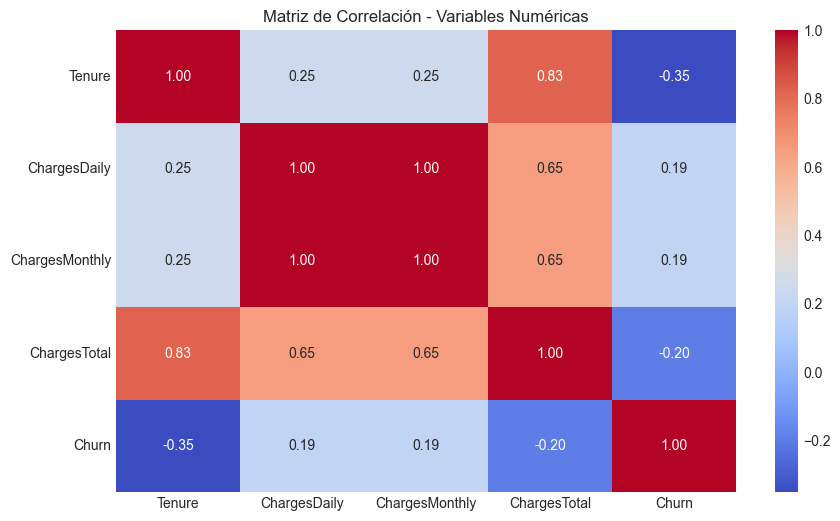

🔎 Pares con posible multicolinealidad (Correlación > 90%):
       Variable_1    Variable_2  Correlacion_%
2  ChargesMonthly  ChargesDaily      99.999564


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar variables numéricas
df_numeric = df.select_dtypes(include=["int64", "float64"]).copy()

# Convertir variable objetivo a numérica
df_numeric["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Calcular matriz de correlación
corr_matrix = df_numeric.corr()

# ==============================
# 1️⃣ MATRIZ DE CORRELACIÓN
# ==============================
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación - Variables Numéricas")
plt.show()


# ==============================
# 2️⃣ ANÁLISIS DE PORCENTAJES
# ==============================

# Convertir correlación a porcentaje (valor absoluto)
corr_percent = corr_matrix.abs() * 100

# Crear máscara para evitar duplicados y diagonal
mask = np.triu(np.ones_like(corr_percent, dtype=bool))

# Extraer pares con correlación mayor al 90%
high_corr_pairs = (
    corr_percent.where(~mask)
    .stack()
    .reset_index()
)

high_corr_pairs.columns = ["Variable_1", "Variable_2", "Correlacion_%"]

# Filtrar correlaciones mayores a 90%
high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlacion_%"] > 90]

# Mostrar resultados
print("Pares con posible multicolinealidad (Correlación > 90%):")
print(high_corr_pairs.sort_values(by="Correlacion_%", ascending=False))


### 2 Ingeniería de Características (Feature Engineering)

En esta fase se optimizan y crean variables para mejorar la capacidad predictiva del modelo.

* **Creación de `num_services`**: Variable que cuantifica la intensidad de uso del cliente. Un mayor número de servicios puede reflejar mayor fidelización o mayor complejidad de abandono.
* **Variables derivadas**: Posible creación de ratios como gasto promedio por servicio.
* **Eliminación de variables irrelevantes o redundantes**:

  * `CustomerID` (identificador sin valor predictivo).
  * Análisis de variables altamente correlacionadas que puedan generar multicolinealidad.
* **Análisis de importancia preliminar** para validar aporte de nuevas variables.

---

## 2. Ingeniería de Características

En esta fase se crean nuevas variables que pueden mejorar la capacidad predictiva del modelo.

Se construyó la variable `num_services`, que cuantifica la cantidad de servicios activos por cliente.

Esta variable permite capturar la intensidad de uso del cliente, lo cual puede estar relacionado con su probabilidad de abandono.

In [ ]:
# ============================================================
# 2️⃣ INGENIERÍA DE CARACTERÍSTICAS
# ============================================================

print("Creando nuevas variables...")

# ------------------------------------------------------------
# 2.1 Definición de columnas de servicios
# ------------------------------------------------------------

service_cols = [
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# ------------------------------------------------------------
# 2.2 Función para contar servicios activos
# ------------------------------------------------------------

def count_services(row):
    count = 0
    
    # Internet cuenta si es DSL o Fiber optic
    if row['InternetService'] != 'No':
        count += 1
    
    # El resto cuenta si el valor es "Yes"
    for col in service_cols:
        if col != 'InternetService' and row[col] == 'Yes':
            count += 1
            
    return count

# ------------------------------------------------------------
# 2.3 Aplicación de la función
# ------------------------------------------------------------

df['num_services'] = df.apply(count_services, axis=1)

print(f"Variable 'num_services' creada. Rango: {df['num_services'].min()} - {df['num_services'].max()}")

#### Creación de la variable `num_services`

Se construyó una nueva variable que cuantifica la cantidad de servicios activos contratados por cada cliente.

La lógica aplicada fue:

- Si el cliente posee Internet (DSL o Fiber optic), se considera 1 servicio.
- Se suma 1 por cada servicio adicional activo (`Yes`).
- Servicios sin contratación o con valor "No internet service" no se contabilizan.

Esta variable busca capturar la intensidad de uso del cliente, ya que un mayor número de servicios puede estar asociado con mayor fidelización o mayor complejidad de abandono.


###  Preprocesamiento de Datos (Data Preprocessing)

Preparación técnica de los datos para su uso en modelos de Machine Learning.

* **Codificación de Variables Categóricas**:

  * One-Hot Encoding para variables nominales (ej. `PaymentMethod`).
  * Label Encoding para la variable objetivo (`Churn`: 0 = No, 1 = Sí).

* **Escalado de Variables Numéricas**:

  * Estandarización (StandardScaler) o Normalización (MinMaxScaler).
  * Aplicado a variables como:

    * `Tenure`
    * `ChargesMonthly`
    * `num_services`



In [ ]:


# 2. Codificación de la variable objetivo (Churn: Yes/No -> 1/0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 3. Identificación de variables para el ColumnTransformer
numeric_cols = ['Tenure', 'ChargesMonthly', 'num_services']
categorical_cols = [col for col in df.columns if col not in numeric_cols + ['Churn']]

# 4. Simplificación de valores en variables categóricas (No internet service -> No)

cols_to_fix = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

for col in cols_to_fix:
    df[col] = df[col].replace({'No internet service': 'No'})

# El siguiente paso sería aplicar el Pipeline con OneHotEncoder y MinMaxScaler
print("\n✅ Columnas redundantes eliminadas y dataset listo para encoding/scaling.")

### Estandarización de categorías

Se reemplazaron los valores "No internet service" por "No" en variables relacionadas con servicios adicionales.

Esto evita crear categorías artificiales al aplicar One-Hot Encoding y simplifica la interpretación del modelo.

In [ ]:
df_numeric = df.select_dtypes(include=["int64", "float64"])

df_numeric["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

corr_matrix = df_numeric.corr()

# Visualizar heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación - Variábles Numericas")
plt.show()

### Matriz de correlación

Se analizó la correlación entre variables numéricas y la variable objetivo.

Este análisis permite identificar:

- Variables con mayor asociación lineal con churn.
- Posible multicolinealidad.
- Variables con bajo poder explicativo.